### Session 9. More on Neural Networks


#### Image classification of fashion items 📷

In this notebook, we will summarize all the components for training a neural network over a new image classification task.

In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

/Users/victorgallego/miniforge3/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


PyTorch offers domain-specific libraries such as `TorchText`, `TorchVision`, and `TorchAudio`, all of which include datasets. For this class, we'll be using a TorchVision dataset.

The ``torchvision.datasets`` module contains ``Dataset`` objects for many real-world vision datasets, such as CIFAR and COCO. In this class, we'll use the **FashionMNIST** dataset.

FashionMNIST was created by [Zalando](https://www.zalando.es), and contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

![Fashion-MNIST samples](images/fashion-mnist-sprite.png)

Each training and test example is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

#### 1. Set up the DataLoaders

We'll use the `torchvision` module to load and transform the FashionMNIST dataset. The code below will load the FashionMNIST dataset. Instead of spliting the data into a training and validation set, this dataset is already split. We'll use the `train` set to train the model and the `test` set to evaluate it.


In the following cell, we wrap it in a `DataLoader` that will **batch** and shuffle the data.

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26421880/26421880 [00:02<00:00, 11284071.54it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 937108.79it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 8142683.28it/s] 


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10336178.55it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


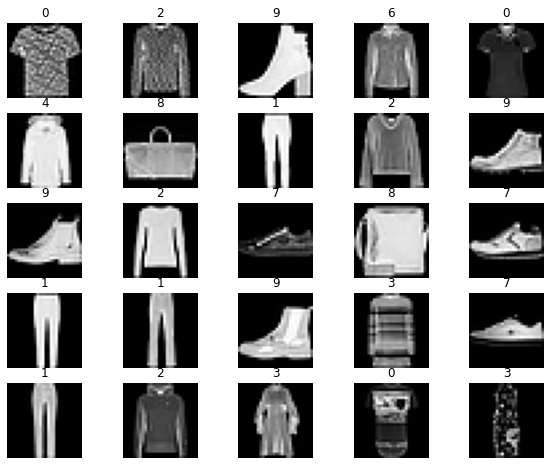

In [4]:
# Display sample data
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    idx = torch.randint(len(test_data), size=(1,)).item()
    img, label = test_data[idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

#### 2. Create the model

To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the __init__ function and specify how data will pass through the network in the forward function. 

* ⚠️ Note here we are using a new layer: `nn.Flatten`, which reshapes the 2D image data into an array (so it can be multiplied as a vector in the following layers).
https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html

In [5]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # The Flatten layer converts each 2D 28x28 image into a contiguous array of 784 pixel values (the minibatch dimension (at dim=0) is maintained).
        self.flatten = nn.Flatten()
        self.linear_1 = nn.Linear(28*28, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_1(x)
        x = nn.ReLU()(x)
        x = self.linear_2(x)
        x = nn.ReLU()(x)
        x = self.linear_3(x)

        # We don't need to apply the softmax activation here. When it is not included, the loss function will automatically apply it. In the previous class we made it explicit for the sake of clarity.
        return x

model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=784, out_features=128, bias=True)
  (linear_2): Linear(in_features=128, out_features=64, bias=True)
  (linear_3): Linear(in_features=64, out_features=10, bias=True)
)


#### 3. Train the model and then evaluate

To train a model, we need a loss function and an optimizer. We'll be using nn.CrossEntropyLoss for loss and Stochastic Gradient Descent for optimization.

In [6]:
loss_fn = nn.CrossEntropyLoss()  # applies the softmax at the end to get probabilities of each class
learning_rate = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and back-propagates the prediction error to adjust the model's parameters. 

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We can also check the model's performance against the test dataset to ensure it is learning.

In [8]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (epochs). During each epoch, the model learns parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the accuracy increase and the loss decrease with every epoch.

In [9]:
epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
print("Done!") 

Epoch 1
-------------------------------
loss: 2.289097  [    0/60000]
loss: 2.204153  [ 6400/60000]
loss: 2.007140  [12800/60000]
loss: 1.802666  [19200/60000]
loss: 1.406623  [25600/60000]
loss: 1.252974  [32000/60000]
loss: 1.139174  [38400/60000]
loss: 1.009746  [44800/60000]
loss: 0.990271  [51200/60000]
loss: 0.889658  [57600/60000]
Test Error: 
 Accuracy: 67.9%, Avg loss: 0.013709 

Epoch 2
-------------------------------
loss: 0.927257  [    0/60000]
loss: 0.924171  [ 6400/60000]
loss: 0.681874  [12800/60000]
loss: 0.846820  [19200/60000]
loss: 0.691251  [25600/60000]
loss: 0.678255  [32000/60000]
loss: 0.771630  [38400/60000]
loss: 0.759616  [44800/60000]
loss: 0.723761  [51200/60000]
loss: 0.680475  [57600/60000]
Test Error: 
 Accuracy: 76.2%, Avg loss: 0.010562 

Epoch 3
-------------------------------
loss: 0.618100  [    0/60000]
loss: 0.711628  [ 6400/60000]
loss: 0.482961  [12800/60000]
loss: 0.697245  [19200/60000]
loss: 0.599393  [25600/60000]
loss: 0.565808  [32000/600

KeyboardInterrupt: 

**Exercise** What is the best test accuracy you can achieve?

You can play with the architecture and/or the hyperparameters.

#### 4. Making predictions

Once the model is trained, we can use it to make predictions. We'll use the `argmax` function to get the index of the max value in the output of the model. This index corresponds to the predicted class of clothing.

Predicted: "Sandal", Actual: "Sneaker"


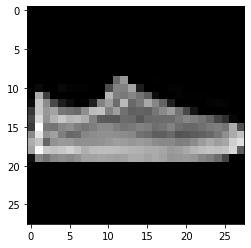

In [21]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()

example_idx = 13
x, y = test_data[example_idx][0], test_data[example_idx][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

    # plot the image
    plt.imshow(x.squeeze(), cmap="gray")

**Exercise** Can you look for three examples of misclassified items?

Are the mistakes reasonable?